In [1]:
import numpy as np
from deep_dating.preprocessing import Preprocessor
from deep_dating.prediction import DatingPredictor
from deep_dating.metrics import DatingMetrics
from deep_dating.util import save_figure
import matplotlib.pyplot as plt

Seed set to 42


In [2]:
all_labels_, all_outputs_, all_paths_ = DatingPredictor.load("predictions.pkl")

In [3]:
preds = {}

for i, img_name in enumerate(all_paths_):
    img_name = Preprocessor.get_base_img_name(img_name)
    if not img_name in preds:
        preds[img_name] = [all_labels_[i, :], [all_outputs_[i, :]]]
    else:
        preds[img_name][1].append(all_outputs_[i, :])

In [4]:
labels = []
img_preds = []
for val in preds.values():
    labels.append(val[0].tolist()[0])
    img_preds.append(np.array(val[1]).squeeze())

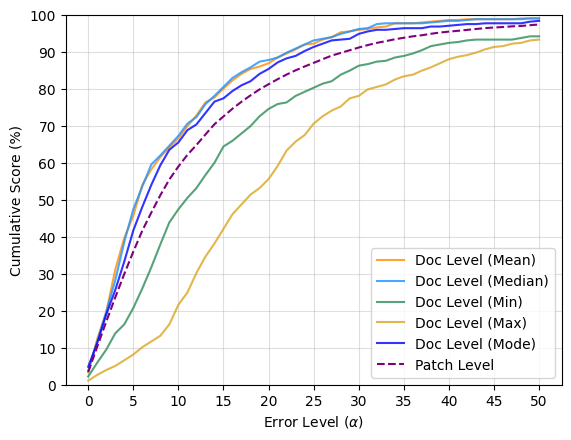

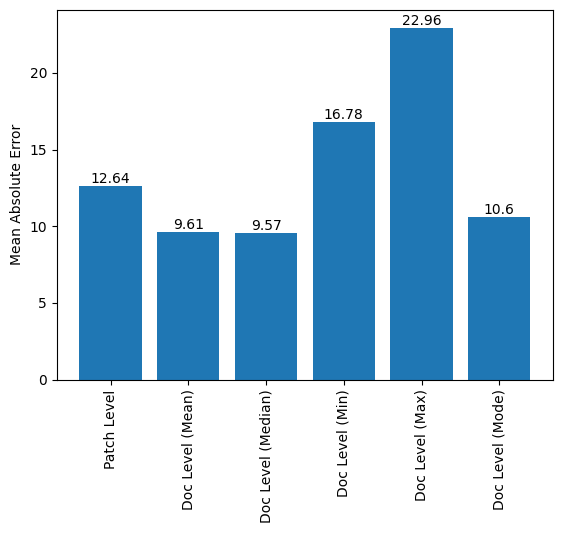

In [11]:
alphas = np.arange(0, 51)
metrics = DatingMetrics(alphas=alphas)

def mode(arr):
    arr = np.round(arr)
    vals, counts = np.unique(arr, return_counts=True)
    index = np.random.choice(np.flatnonzero(counts == counts.max()))
    return vals[index]

agg_funcs = [("Mean", "darkorange", np.mean), ("Median", "dodgerblue", np.median), 
             ("Min", "seagreen", np.min), ("Max", "goldenrod", np.max),
             ("Mode", "blue", mode)]

maes = []
names = []

fig_cs, ax_cs = plt.subplots()
fig_mae, ax_mae = plt.subplots()

for func_name, color, func in agg_funcs:
    pred_agg = []
    label = f"Doc Level ({func_name})"

    for img_vals in img_preds:
        pred_agg.append(func(img_vals))

    metric_vals = metrics.calc(labels, pred_agg)
    mae, mse = tuple(metric_vals[:2])
    maes.append(mae)
    names.append(label)
    cs = metric_vals[2:]
    ax_cs.plot(alphas, cs, label=label, color=color, alpha=0.8)

metric_vals = metrics.calc(all_labels_, all_outputs_)
mae, mse = tuple(metric_vals[:2])
cs = metric_vals[2:]

ax_cs.plot(alphas, cs, label="Patch Level", linestyle="--", color="purple")
ax_cs.set_xlabel(r"Error Level ($\alpha$)")
ax_cs.set_ylabel("Cumulative Score (%)")
ax_cs.set_ylim(0, 100)
ax_cs.set_yticks(np.arange(0, 110, 10))
ax_cs.set_xticks(np.arange(0, 55, 5))
#ax_cs.axvline(x=25, color="red", alpha=0.7)
ax_cs.legend()
ax_cs.grid(alpha=0.4)
save_figure("cs", fig=fig_cs)

ax_mae.bar(["Patch Level"] + names, np.round([mae] + maes, 2))
for bars in ax_mae.containers:
    ax_mae.bar_label(bars)

for tick in ax_mae.get_xticklabels():
    tick.set_rotation(90)

ax_mae.set_ylabel("Mean Absolute Error")
save_figure("mae", fig=fig_mae, show=True)